In [26]:
import mlflow
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import tensorflow_recommenders as tfrs

# MLFlow setup

In [27]:
experiment_name = "Joropo_Expreriment"

if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name) 

experiment = mlflow.get_experiment_by_name(experiment_name)

# Variables

In [28]:
path_data = "../data/processed/processed.parquet"
epochs = 15
embedding_dimension = 1024
layers_size = "128 64 1"
learning_rate = 0


# Functions

In [29]:
def plot_loss(m):
    plt.plot(m.history['loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Loss'], loc='upper right')
    plt.show()    

In [30]:
def plot_metrics(m):
    plt.plot(m.history['root_mean_squared_error']) 
    plt.title('Model root_mean_squared_error') 
    plt.ylabel('root_mean_squared_error') 
    plt.xlabel('Epoch') 
    plt.legend(['root_mean_squared_error'], loc='upper right')
    plt.show()

In [31]:
def find_lower_value(list_of_integers):
  lower_value = list_of_integers[0]
  for integer in list_of_integers:
    if integer < lower_value:
      lower_value = integer

  return lower_value

# Load data

In [32]:
df = pd.read_parquet(path_data)

In [33]:
unique_asin = df.asin.unique()
unique_reviewerID = df.reviewerID.unique()
total_ratings= len(df.index)

# Create classes

In [34]:
class RankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()       

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_reviewerID, mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_reviewerID)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_asin , mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_asin)+1, embedding_dimension)
                                    ])
        self.ratings = tf.keras.Sequential([      
                            tf.keras.layers.Dense(128, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

In [35]:
class amazonModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["reviewerID"], features["asin"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [36]:
ratings = tf.data.Dataset.from_tensor_slices( {"reviewerID":tf.cast( df.reviewerID.values, tf.string),
                                                "asin":tf.cast( df.asin.values, tf.string),
                                                "rating": df.rating.values.astype('int16')     } )

In [37]:
tf.random.set_seed(42)

shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

# Compile, fit and evaluate the model

In [38]:
Loss_call_back = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, verbose=1, mode='min')

In [39]:
model = amazonModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=learning_rate ))

In [40]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [41]:
model_hist = model.fit(cached_train, 
                            epochs=epochs, 
                            callbacks=[Loss_call_back])

Epoch 1/15


144/144 [==============================] - 174s 327ms/step - root_mean_squared_error: 1.4524 - loss: 2.1005 - regularization_loss: 0.0000e+00 - total_loss: 2.1005
Epoch 2/15
144/144 [==============================] - 41s 285ms/step - root_mean_squared_error: 1.3143 - loss: 1.7201 - regularization_loss: 0.0000e+00 - total_loss: 1.7201
Epoch 3/15
144/144 [==============================] - 40s 280ms/step - root_mean_squared_error: 1.3085 - loss: 1.7012 - regularization_loss: 0.0000e+00 - total_loss: 1.7012
Epoch 4/15
144/144 [==============================] - 39s 270ms/step - root_mean_squared_error: 1.3025 - loss: 1.6818 - regularization_loss: 0.0000e+00 - total_loss: 1.6818
Epoch 5/15
144/144 [==============================] - 40s 276ms/step - root_mean_squared_error: 1.2963 - loss: 1.6625 - regularization_loss: 0.0000e+00 - total_loss: 1.6625
Epoch 6/15
144/144 [==============================] - 40s 277ms/step - root_mean_squared_error: 1.2896 - loss: 1.6434 - regularization_loss: 0.00

In [42]:
RootMeanSquaredError = find_lower_value(model_hist.history['root_mean_squared_error'])
Loss = find_lower_value(model_hist.history['loss'])
regularization_loss = find_lower_value(model_hist.history['regularization_loss'])

In [43]:
mlflow.start_run(experiment_id=experiment.experiment_id)

mlflow.log_param("epochs", epochs)
mlflow.log_param("embedding_dimension", embedding_dimension)
mlflow.log_param("learning_rate", learning_rate)

mlflow.log_metric("RootMeanSquaredError", RootMeanSquaredError)
mlflow.log_metric("Loss", Loss)
mlflow.log_metric("Regularization_Loss", regularization_loss)

In [44]:
eval = model.evaluate(cached_test, return_dict=True)

72/72 [==============================] - 12s 56ms/step - root_mean_squared_error: 1.3155 - loss: 1.7300 - regularization_loss: 0.0000e+00 - total_loss: 1.7300


In [45]:
mlflow.log_metric("y_RootMeanSquaredError", eval["root_mean_squared_error"])
mlflow.log_metric("y_Loss", eval["loss"])
mlflow.log_metric("y_Regularization_Loss", eval["regularization_loss"])
mlflow.log_param("Dropout", "0.2")
mlflow.end_run()

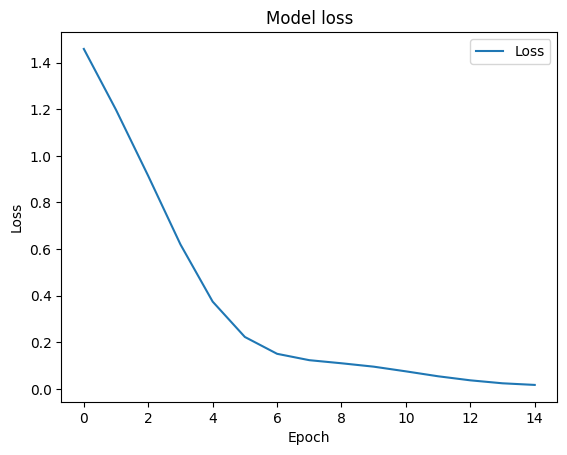

In [46]:
plot_loss(model_hist)

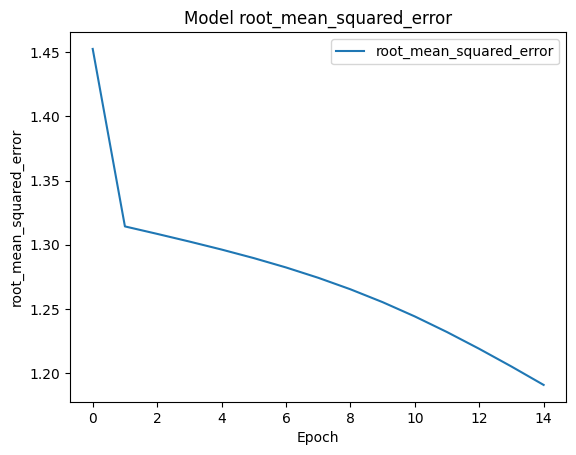

In [47]:
plot_metrics(model_hist)

# Some manual test

In [48]:
# unique_reviewerID[15488]

In [49]:
# user_rand = unique_reviewerID[123]
# test_rating = {}
# for m in test.take(5):   
#     test_rating[m["asin"].numpy()] = RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["asin"]]))

In [50]:
# print("Top 5 recommended products for User {}: ".format(user_rand))

# for m in sorted(test_rating, key=test_rating.get, reverse=True):
#     print(m.decode())